# Create the environment with different reward functions

In [4]:
import numpy as np
from gym_unbalanced_disk import UnbalancedDisk
from gymnasium import spaces

class AC_UnbalancedDisk1(UnbalancedDisk):
    def __init__(self, umax=3., dt=0.025, render_mode='human', randomize_friction=True):
        super().__init__(umax=umax, dt=dt, render_mode=render_mode)

        self.target = np.pi
        self.randomize_friction = randomize_friction  

        low = [-np.pi, -40]
        high = [np.pi, 40]
        self.observation_space = spaces.Box(
            low=np.array(low, dtype=np.float32),
            high=np.array(high, dtype=np.float32),
            shape=(2,)
        )

        self.recent_omegas = []

    def step(self, action):
        # Sample a new random friction multiplier every step if enabled
        friction_scale = np.random.uniform(0.6, 1.5) if self.randomize_friction else 1.0

        # Temporarily patch gamma and Fc
        original_gamma = self.gamma
        original_Fc = self.Fc
        self.gamma *= friction_scale
        self.Fc *= friction_scale

        # Do the physics step using modified friction
        obs, reward, terminated, truncated, info = super().step(action)

        # Restore friction coefficients
        self.gamma = original_gamma
        self.Fc = original_Fc

        # Reward logic
        th = obs[0]
        omega = obs[1]
        theta = ((th - np.pi) % (2 * np.pi)) - np.pi
        self.recent_omegas.append(omega)
        if len(self.recent_omegas) > 10:
            self.recent_omegas.pop(0)

        if abs(theta) < np.pi / 2:
            reward = min(-1, -(np.pi) -1 + abs(omega))
        elif abs(theta) > np.pi / 2 and abs(theta) < 3 * np.pi / 4:
            reward = abs(theta)**2 / (1 + abs(omega))
        else:
            reward = abs(theta)**4 / (1 + abs(omega))**2

        return obs, reward, terminated, truncated, info

    def reset(self, seed=None, options=None):
        obs, info = super().reset()
        self.recent_omegas = []
        return obs, info


In [5]:
import numpy as np
from gym_unbalanced_disk import UnbalancedDisk
from gymnasium import spaces

class AC_UnbalancedDisk5(UnbalancedDisk):
    def __init__(self, umax=3., dt=0.025, render_mode='human', randomize_friction=True):
        super().__init__(umax=umax, dt=dt, render_mode=render_mode)

        self.target = np.pi
        self.randomize_friction = randomize_friction

        low = [-np.pi, -40]
        high = [np.pi, 40]
        self.observation_space = spaces.Box(
            low=np.array(low, dtype=np.float32),
            high=np.array(high, dtype=np.float32),
            shape=(2,)
        )

        self.recent_omegas = []

    def step(self, action):
        # Sample a new random friction multiplier every step if enabled
        friction_scale = np.random.uniform(0.6, 1.5) if self.randomize_friction else 1.0

        # Temporarily patch gamma and Fc
        original_gamma = self.gamma
        original_Fc = self.Fc
        self.gamma *= friction_scale
        self.Fc *= friction_scale

        # Perform physics step
        obs, reward, terminated, truncated, info = super().step(action)

        # Restore original friction
        self.gamma = original_gamma
        self.Fc = original_Fc

        # Extract angle and angular velocity
        th = obs[0]
        omega = obs[1]

        # # Normalize angle around π (i.e., make π → 0)
        # theta = ((th - np.pi) % (2 * np.pi)) - np.pi
        # theta_abs = abs(theta)
        # omega_abs = abs(omega)

        # # Apply reward based on region
        # if theta_abs <= 0.5 * np.pi:
        #     reward = min(-1, -(np.pi) - 1 + abs(omega))
        # elif theta_abs <= 0.75 * np.pi:
        #     reward = (-np.cos(theta_abs)) / (0.1 + omega_abs)
        # else:
        #     reward = 5*(-np.cos(theta_abs))**0.5 / (0.1 + omega_abs)
        #     # Add anti-stall penalty
        #     # Stall detection: angular velocity near zero for several steps
        #     if all(abs(w) < 0.005 for w in self.recent_omegas):
        #         reward = 1 / (1 + abs(omega))


        theta_abs = np.abs(((th + np.pi) % (2 * np.pi)) - np.pi)  # shortest distance to target (π)
        omega_abs = np.abs(omega)

        # Region 1: θ < 0.5π
        if theta_abs < 0.5 * np.pi:
            if omega_abs < 5:
                reward = np.maximum(-omega_abs**2, -0.5) - np.abs(2 * np.sin(0.5 * (np.pi - np.pi * (omega_abs) / 5)))
            else:
                reward = np.maximum(-omega_abs**2, -0.5)

        # Region 2: 0.5π ≤ θ < 0.75π
        elif 0.5 * np.pi <= theta_abs < 0.75 * np.pi:
            reward = 2 * (-np.cos(theta_abs)) / (0.01 + omega_abs)

        else:
            reward = (-np.cos(theta_abs - np.pi / 4))**0.5 / (0.01 + omega_abs**2)

        return obs, reward, terminated, truncated, info

    def reset(self, seed=None, options=None):
        obs, info = super().reset()
        return obs, info


## import necessary libraries

In [6]:
from gymnasium.wrappers import TimeLimit
from stable_baselines3 import PPO, SAC
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import StopTrainingOnMaxEpisodes

##  Plot the angle VS time for the best performing models SAC and DQN for both reward functions

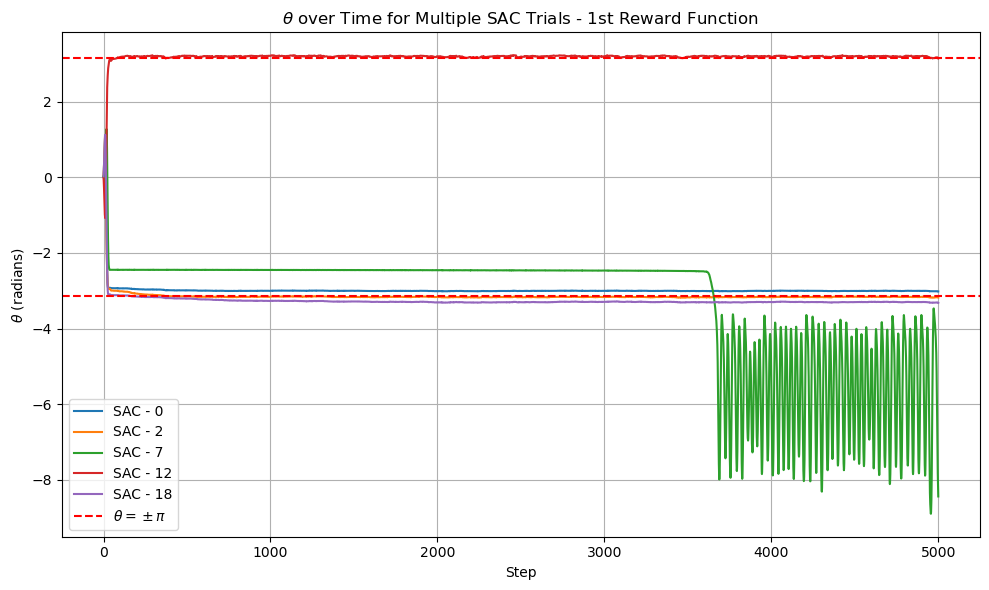

In [7]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import SAC

# Constants
base_dir = "SAc - 1"
timesteps = 5000

# Collect and sort folders
subfolders = [f for f in os.listdir(base_dir) if f.startswith("optuna_best_model_trial_")]
subfolders.sort(key=lambda x: int(re.findall(r'\d+', x)[0]))

plt.figure(figsize=(10, 6))

# Plot each model
for folder in subfolders:
    trial_num = re.findall(r'\d+', folder)[0]
    model_path = os.path.join(base_dir, folder, "best_model.zip")
    model = SAC.load(model_path)

    env = AC_UnbalancedDisk1()
    obs, _ = env.reset()

    theta_values = []
    steps = []

    for i in range(timesteps):
        action, _ = model.predict(obs)
        obs, reward, terminated, truncated, info = env.step(action)
        theta = obs[0]
        theta_values.append(theta)
        steps.append(i)
        if terminated or truncated:
            obs, _ = env.reset()

    env.close()
    plt.plot(steps, theta_values, label=f"SAC - {trial_num}")

# Add goal/reference lines at ±π
plt.axhline(y=np.pi, color='red', linestyle='--', label=r'$\theta = \pm \pi$')
plt.axhline(y=-np.pi, color='red', linestyle='--')  # Same label not needed twice

# Plot formatting
plt.xlabel("Step")
plt.ylabel(r"$\theta$ (radians)")
plt.title(r"$\theta$ over Time for Multiple SAC Trials - 1st Reward Function")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


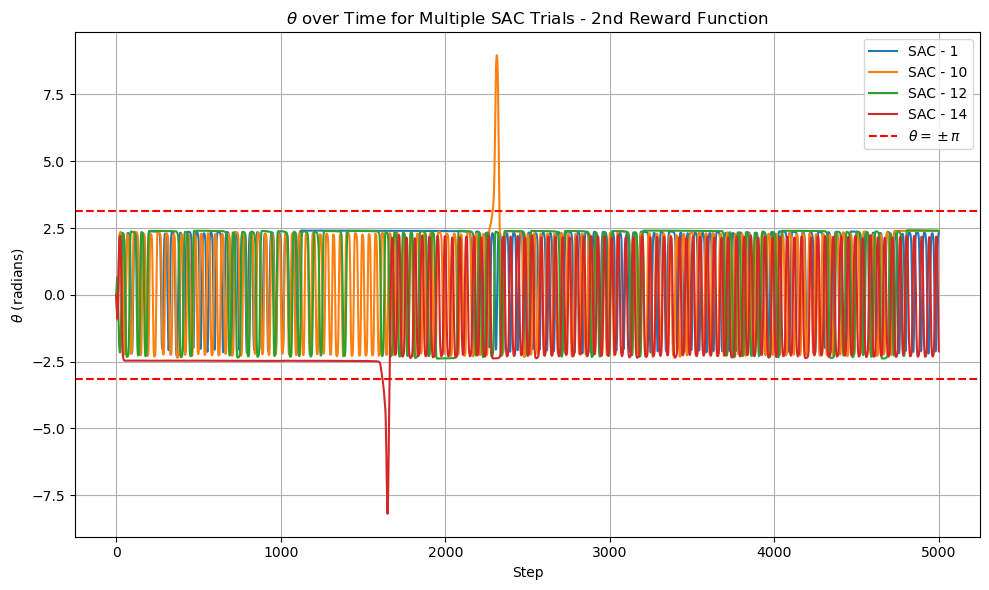

In [8]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import SAC

# Constants
base_dir = "SAC - 2"
timesteps = 5000

# Collect and sort folders
subfolders = [f for f in os.listdir(base_dir) if f.startswith("optuna_best_model5_trial_")]
subfolders.sort(key=lambda x: int(re.search(r'trial_(\d+)', x).group(1)))

plt.figure(figsize=(10, 6))

# Plot each model
for folder in subfolders:
    trial_match = re.search(r'trial_(\d+)', folder)
    trial_num = trial_match.group(1) if trial_match else "?"
    model_path = os.path.join(base_dir, folder, "best_model.zip")
    model = SAC.load(model_path)

    env = AC_UnbalancedDisk5()
    obs, _ = env.reset()

    theta_values = []
    steps = []

    for i in range(timesteps):
        action, _ = model.predict(obs)
        obs, reward, terminated, truncated, info = env.step(action)
        theta = obs[0]
        theta_values.append(theta)
        steps.append(i)
        if terminated or truncated:
            obs, _ = env.reset()

    env.close()
    plt.plot(steps, theta_values, label=f"SAC - {trial_num}")

# Add goal/reference lines at ±π
plt.axhline(y=np.pi, color='red', linestyle='--', label=r'$\theta = \pm \pi$')
plt.axhline(y=-np.pi, color='red', linestyle='--')

# Plot formatting
plt.xlabel("Step")
plt.ylabel(r"$\theta$ (radians)")
plt.title(r"$\theta$ over Time for Multiple SAC Trials - 2nd Reward Function")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


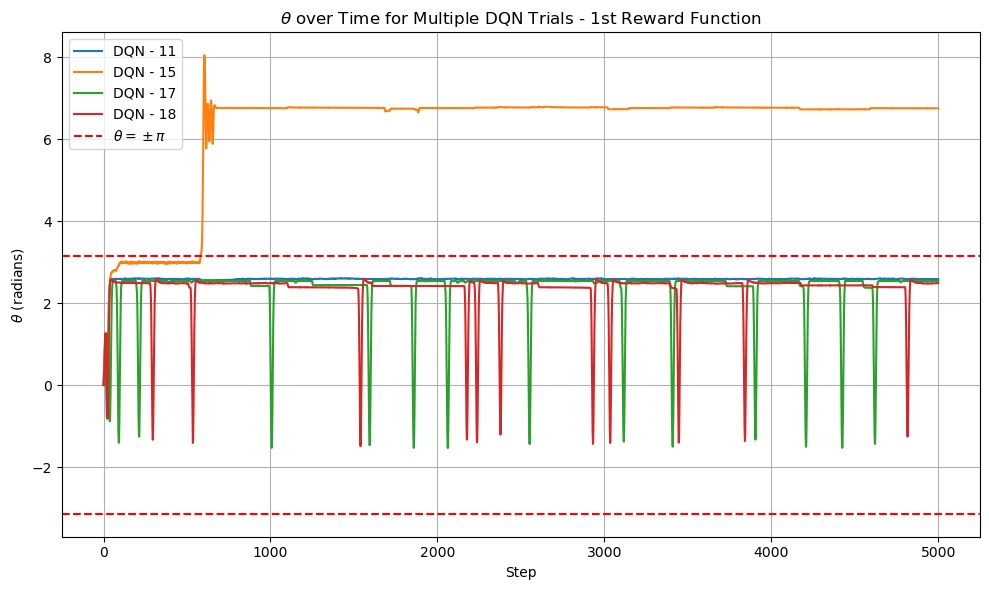

In [9]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import DQN

# Constants
base_dir = "DQN - 1"
timesteps = 5000

# Collect and sort folders by trial number
subfolders = [f for f in os.listdir(base_dir) if f.startswith("optuna_best_model_trial_")]
subfolders.sort(key=lambda x: int(re.search(r'trial_(\d+)', x).group(1)))

plt.figure(figsize=(10, 6))

# Plot each model
for folder in subfolders:
    trial_match = re.search(r'trial_(\d+)', folder)
    trial_num = trial_match.group(1) if trial_match else "?"

    model_path = os.path.join(base_dir, folder, "best_model.zip")
    model = DQN.load(model_path)

    env = AC_UnbalancedDisk1()
    obs, _ = env.reset()

    theta_values = []
    steps = []

    for i in range(timesteps):
        action, _ = model.predict(obs)
        obs, reward, terminated, truncated, info = env.step(action)
        theta = obs[0]
        theta_values.append(theta)
        steps.append(i)

        if terminated or truncated:
            obs, _ = env.reset()

    env.close()
    plt.plot(steps, theta_values, label=f"DQN - {trial_num}")

# Add reference lines at ±π
plt.axhline(y=np.pi, color='red', linestyle='--', label=r'$\theta = \pm \pi$')
plt.axhline(y=-np.pi, color='red', linestyle='--')

# Formatting
plt.xlabel("Step")
plt.ylabel(r"$\theta$ (radians)")
plt.title(r"$\theta$ over Time for Multiple DQN Trials - 1st Reward Function")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


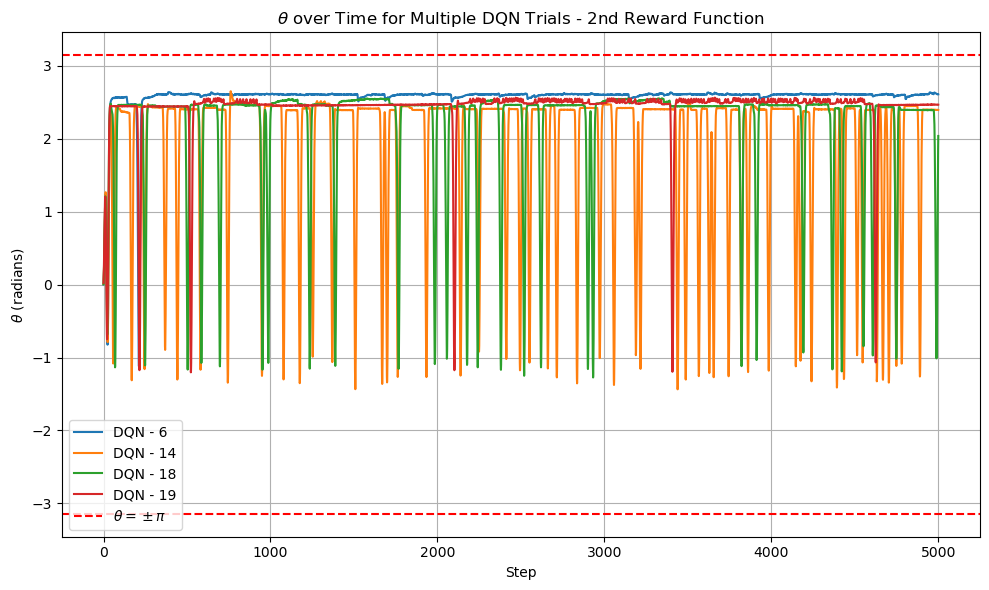

In [10]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import DQN

# Constants
base_dir = "DQN - 2"
timesteps = 5000

# Collect and sort folders by trial number
subfolders = [f for f in os.listdir(base_dir) if f.startswith("optuna_best_model_trial_")]
subfolders.sort(key=lambda x: int(re.search(r'trial_(\d+)', x).group(1)))

plt.figure(figsize=(10, 6))

# Plot each model
for folder in subfolders:
    trial_match = re.search(r'trial_(\d+)', folder)
    trial_num = trial_match.group(1) if trial_match else "?"

    model_path = os.path.join(base_dir, folder, "best_model.zip")
    model = DQN.load(model_path)

    env = AC_UnbalancedDisk1()
    obs, _ = env.reset()

    theta_values = []
    steps = []

    for i in range(timesteps):
        action, _ = model.predict(obs)
        obs, reward, terminated, truncated, info = env.step(action)
        theta = obs[0]
        theta_values.append(theta)
        steps.append(i)

        if terminated or truncated:
            obs, _ = env.reset()

    env.close()
    plt.plot(steps, theta_values, label=f"DQN - {trial_num}")

# Add reference lines at ±π
plt.axhline(y=np.pi, color='red', linestyle='--', label=r'$\theta = \pm \pi$')
plt.axhline(y=-np.pi, color='red', linestyle='--')

# Formatting
plt.xlabel("Step")
plt.ylabel(r"$\theta$ (radians)")
plt.title(r"$\theta$ over Time for Multiple DQN Trials - 2nd Reward Function")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [9]:
from stable_baselines3 import SAC
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnMaxEpisodes
from stable_baselines3.common.env_util import make_vec_env
from gymnasium.wrappers import TimeLimit

# Training environment
env = AC_UnbalancedDisk5()
env = TimeLimit(env, max_episode_steps=500)
env = Monitor(env)

# Separate eval environment for unbiased performance tracking
eval_env = AC_UnbalancedDisk5(randomize_friction=False)
eval_env = TimeLimit(eval_env, max_episode_steps=500)
eval_env = Monitor(eval_env)

# Stop after 100 episodes
stop_cb = StopTrainingOnMaxEpisodes(max_episodes=100, verbose=1)

# Save best model based on mean reward
eval_cb = EvalCallback(
    eval_env,
    best_model_save_path="./best_sac_model5",
    log_path="./logs",
    eval_freq=5000,
    deterministic=True,
    render=False
)

# Chain both callbacks
from stable_baselines3.common.callbacks import CallbackList
callback = CallbackList([stop_cb, eval_cb])

# Model
model_sac3 = SAC(
    policy='MlpPolicy',
    env=env,
    # learning_rate=1e-3,
    verbose=1,
    # ent_coef=1e-2,
)

# Train
model_sac3.learn(
    total_timesteps=1_000_000,
    callback=callback,
)



Using cuda device
Wrapping the env in a DummyVecEnv.


RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [6]:
# To use the best-performing model
from stable_baselines3 import SAC
model_sac3 = SAC.load("./best_sac_model5/best_model.zip")

env = AC_UnbalancedDisk5()
obs, _ = env.reset()
for i in range(5000):
    action, _states = model_sac3.predict(obs)  # policy
    obs, reward, terminated, truncated, info = env.step(action)
    env.render()
    t = obs[0]
    print( f'theta = {t: .4f}, omega: {obs[1]: .4f}')
    if terminated or truncated:
        obs, _ = env.reset()
    
env.close()

/home/kostas/anaconda3/envs/gpy-env/lib/python3.10/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


theta =  0.0246, omega:  1.8131
theta =  0.0893, omega:  3.4955
theta =  0.1941, omega:  4.7969
theta =  0.3272, omega:  5.6535
theta =  0.4760, omega:  6.1874
theta =  0.6314, omega:  6.1742
theta =  0.7841, omega:  5.8762
theta =  0.8779, omega:  1.7400
theta =  0.8642, omega: -2.6962
theta =  0.7469, omega: -6.7287
theta =  0.5301, omega: -10.2511
theta =  0.2423, omega: -12.8907
theta = -0.1036, omega: -14.4462
theta = -0.4688, omega: -14.7490
theta = -0.8323, omega: -14.0998
theta = -1.1618, omega: -12.1638
theta = -1.4434, omega: -10.3682
theta = -1.6768, omega: -8.2231
theta = -1.8506, omega: -5.7924
theta = -1.9654, omega: -3.2313
theta = -2.0279, omega: -2.0337
theta = -2.0682, omega: -1.0089
theta = -2.0816, omega: -0.1217
theta = -2.0764, omega:  0.4873
theta = -2.0520, omega:  1.4395
theta = -1.9613, omega:  5.8869
theta = -1.7611, omega:  10.0112
theta = -1.4724, omega:  13.1479
theta = -1.1114, omega:  15.5460
theta = -0.7185, omega:  15.8737
theta = -0.3010, omega:  17.2

# Optuna hyperparameter optimization

## SAC with 1st reward function

In [4]:
import optuna
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler
import torch
import numpy as np
import random

from stable_baselines3 import SAC
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnMaxEpisodes, CallbackList
from gymnasium.wrappers import TimeLimit



# def set_seed(seed):
#     np.random.seed(seed)
#     random.seed(seed)
#     torch.manual_seed(seed)

def objective(trial):
    # set_seed(42)  # Fixed seed for reproducibility

    # Sample hyperparameters
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True)
    # ent_coef = trial.suggest_float("ent_coef", 1e-5, 0.1, log=True)
    gamma = trial.suggest_float("gamma", 0.90, 0.9999)
    tau = trial.suggest_float("tau", 0.005, 0.02)
    batch_size = trial.suggest_categorical("batch_size", [64, 128, 256])
    buffer_size = trial.suggest_categorical("buffer_size", [100_000, 200_000, 500_000])

    # Training env
    env = Monitor(TimeLimit(AC_UnbalancedDisk1(randomize_friction=True), max_episode_steps=500))

    # Evaluation env (no random friction)
    eval_env = Monitor(TimeLimit(AC_UnbalancedDisk1(randomize_friction=False), max_episode_steps=500))

    # Callbacks
    stop_cb = StopTrainingOnMaxEpisodes(max_episodes=100, verbose=1)
    eval_cb = EvalCallback(
        eval_env,
        best_model_save_path=f"./optuna_best_model_trial_{trial.number}",
        log_path=None,
        eval_freq=5000,
        deterministic=True,
        render=False,
    )
    callback = CallbackList([stop_cb, eval_cb])

    # Model
    model = SAC(
        "MlpPolicy",
        env,
        learning_rate=learning_rate,
        # ent_coef=ent_coef,
        gamma=gamma,
        tau=tau,
        batch_size=batch_size,
        buffer_size=buffer_size,
        verbose=1,
        seed=42,
    )

    model.learn(total_timesteps=1_000_000, callback=callback)

    return eval_cb.best_mean_reward

# Optuna study
study = optuna.create_study(direction="maximize", sampler=TPESampler(), pruner=MedianPruner())
study.optimize(objective, n_trials=20)

# Show best result
print("Best trial value:", study.best_trial.value)
print("Best hyperparameters:", study.best_trial.params)


[I 2025-06-24 23:28:31,313] A new study created in memory with name: no-name-0d03c79e-3b6c-40bb-a74d-94a80a9215d9


Using cuda device
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 500      |
|    ep_rew_mean     | -616     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 166      |
|    time_elapsed    | 12       |
|    total_timesteps | 2000     |
| train/             |          |
|    actor_loss      | 12.1     |
|    critic_loss     | 0.18     |
|    ent_coef        | 0.423    |
|    ent_coef_loss   | -0.938   |
|    learning_rate   | 0.000474 |
|    n_updates       | 1899     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 500      |
|    ep_rew_mean     | -393     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 172      |
|    time_elapsed    | 23       |
|    total_timesteps | 4000     |
| train/             |          |
|    actor_loss      | -3.07 

[I 2025-06-24 23:34:34,011] Trial 0 finished with value: 34224.6307792 and parameters: {'learning_rate': 0.000474354279954344, 'gamma': 0.9302808876469364, 'tau': 0.019194867926327408, 'batch_size': 64, 'buffer_size': 200000}. Best is trial 0 with value: 34224.6307792.


New best mean reward!
Using cuda device
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 500      |
|    ep_rew_mean     | -715     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 176      |
|    time_elapsed    | 11       |
|    total_timesteps | 2000     |
| train/             |          |
|    actor_loss      | 10.2     |
|    critic_loss     | 0.149    |
|    ent_coef        | 0.764    |
|    ent_coef_loss   | -0.362   |
|    learning_rate   | 0.000146 |
|    n_updates       | 1899     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 500      |
|    ep_rew_mean     | -495     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 170      |
|    time_elapsed    | 23       |
|    total_timesteps | 4000     |
| train/             |          |
|    ac

[I 2025-06-24 23:40:04,946] Trial 1 finished with value: 14241.125571199998 and parameters: {'learning_rate': 0.00014630362957202282, 'gamma': 0.9212240794786876, 'tau': 0.012874174835518566, 'batch_size': 64, 'buffer_size': 200000}. Best is trial 0 with value: 34224.6307792.


Using cuda device
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 500      |
|    ep_rew_mean     | -705     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 183      |
|    time_elapsed    | 10       |
|    total_timesteps | 2000     |
| train/             |          |
|    actor_loss      | 16.1     |
|    critic_loss     | 0.508    |
|    ent_coef        | 0.248    |
|    ent_coef_loss   | -1.22    |
|    learning_rate   | 0.000783 |
|    n_updates       | 1899     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 500      |
|    ep_rew_mean     | -517     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 184      |
|    time_elapsed    | 21       |
|    total_timesteps | 4000     |
| train/             |          |
|    actor_loss      | 17    

[I 2025-06-24 23:46:19,778] Trial 2 finished with value: 36058.882440400004 and parameters: {'learning_rate': 0.0007834432443188773, 'gamma': 0.9769024636267108, 'tau': 0.010217885893668479, 'batch_size': 128, 'buffer_size': 200000}. Best is trial 2 with value: 36058.882440400004.


New best mean reward!
Using cuda device
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 500      |
|    ep_rew_mean     | -732     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 193      |
|    time_elapsed    | 10       |
|    total_timesteps | 2000     |
| train/             |          |
|    actor_loss      | 17.4     |
|    critic_loss     | 1.95     |
|    ent_coef        | 0.933    |
|    ent_coef_loss   | -0.102   |
|    learning_rate   | 3.79e-05 |
|    n_updates       | 1899     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 500      |
|    ep_rew_mean     | -441     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 190      |
|    time_elapsed    | 20       |
|    total_timesteps | 4000     |
| train/             |          |
|    ac

[I 2025-06-24 23:51:38,061] Trial 3 finished with value: 168.349416 and parameters: {'learning_rate': 3.786741067081078e-05, 'gamma': 0.9393858193636887, 'tau': 0.01813802578384543, 'batch_size': 128, 'buffer_size': 100000}. Best is trial 2 with value: 36058.882440400004.


New best mean reward!
Using cuda device
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 500      |
|    ep_rew_mean     | -683     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 171      |
|    time_elapsed    | 11       |
|    total_timesteps | 2000     |
| train/             |          |
|    actor_loss      | 7.94     |
|    critic_loss     | 0.0998   |
|    ent_coef        | 0.631    |
|    ent_coef_loss   | -0.665   |
|    learning_rate   | 0.000248 |
|    n_updates       | 1899     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 500      |
|    ep_rew_mean     | -546     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 177      |
|    time_elapsed    | 22       |
|    total_timesteps | 4000     |
| train/             |          |
|    ac

[I 2025-06-24 23:57:31,698] Trial 4 finished with value: 17528.733320199997 and parameters: {'learning_rate': 0.00024845183461924016, 'gamma': 0.9089596190929427, 'tau': 0.00846116521850958, 'batch_size': 128, 'buffer_size': 100000}. Best is trial 2 with value: 36058.882440400004.


Using cuda device
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 500       |
|    ep_rew_mean     | -1.26e+03 |
| time/              |           |
|    episodes        | 4         |
|    fps             | 166       |
|    time_elapsed    | 12        |
|    total_timesteps | 2000      |
| train/             |           |
|    actor_loss      | 12.3      |
|    critic_loss     | 2.55      |
|    ent_coef        | 0.972     |
|    ent_coef_loss   | -0.0459   |
|    learning_rate   | 1.53e-05  |
|    n_updates       | 1899      |
----------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 500       |
|    ep_rew_mean     | -1.04e+03 |
| time/              |           |
|    episodes        | 8         |
|    fps             | 164       |
|    time_elapsed    | 24        |
|    total_timesteps | 4000      |
| train/             |           |
| 

[I 2025-06-25 00:02:51,559] Trial 5 finished with value: 1187.9961879999998 and parameters: {'learning_rate': 1.5293514611755896e-05, 'gamma': 0.9508377812100572, 'tau': 0.011791540884895993, 'batch_size': 128, 'buffer_size': 500000}. Best is trial 2 with value: 36058.882440400004.


Using cuda device
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 500      |
|    ep_rew_mean     | -690     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 167      |
|    time_elapsed    | 11       |
|    total_timesteps | 2000     |
| train/             |          |
|    actor_loss      | 8.34     |
|    critic_loss     | 0.0499   |
|    ent_coef        | 0.543    |
|    ent_coef_loss   | -0.856   |
|    learning_rate   | 0.000329 |
|    n_updates       | 1899     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 500      |
|    ep_rew_mean     | -536     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 161      |
|    time_elapsed    | 24       |
|    total_timesteps | 4000     |
| train/             |          |
|    actor_loss      | -36.6 

[I 2025-06-25 00:08:08,642] Trial 6 finished with value: 344.689295 and parameters: {'learning_rate': 0.0003287916984615304, 'gamma': 0.9510807030750233, 'tau': 0.005648988142291788, 'batch_size': 128, 'buffer_size': 200000}. Best is trial 2 with value: 36058.882440400004.


Using cuda device
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 500      |
|    ep_rew_mean     | -652     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 194      |
|    time_elapsed    | 10       |
|    total_timesteps | 2000     |
| train/             |          |
|    actor_loss      | 11.5     |
|    critic_loss     | 0.354    |
|    ent_coef        | 0.68     |
|    ent_coef_loss   | -0.495   |
|    learning_rate   | 0.00021  |
|    n_updates       | 1899     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 500      |
|    ep_rew_mean     | -572     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 174      |
|    time_elapsed    | 22       |
|    total_timesteps | 4000     |
| train/             |          |
|    actor_loss      | -57.5 

[I 2025-06-25 00:13:47,864] Trial 7 finished with value: 3926.266184 and parameters: {'learning_rate': 0.00020982928617059934, 'gamma': 0.9310709055718293, 'tau': 0.017615435436039818, 'batch_size': 64, 'buffer_size': 500000}. Best is trial 2 with value: 36058.882440400004.


New best mean reward!
Using cuda device
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 500      |
|    ep_rew_mean     | -672     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 180      |
|    time_elapsed    | 11       |
|    total_timesteps | 2000     |
| train/             |          |
|    actor_loss      | 7.51     |
|    critic_loss     | 0.15     |
|    ent_coef        | 0.658    |
|    ent_coef_loss   | -0.628   |
|    learning_rate   | 0.000225 |
|    n_updates       | 1899     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 500      |
|    ep_rew_mean     | -482     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 184      |
|    time_elapsed    | 21       |
|    total_timesteps | 4000     |
| train/             |          |
|    ac

[I 2025-06-25 00:19:30,792] Trial 8 finished with value: 17122.0071654 and parameters: {'learning_rate': 0.0002254902563306953, 'gamma': 0.9242523675301357, 'tau': 0.00662465757389457, 'batch_size': 64, 'buffer_size': 200000}. Best is trial 2 with value: 36058.882440400004.


Using cuda device
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 500      |
|    ep_rew_mean     | -731     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 201      |
|    time_elapsed    | 9        |
|    total_timesteps | 2000     |
| train/             |          |
|    actor_loss      | 6.58     |
|    critic_loss     | 0.116    |
|    ent_coef        | 0.801    |
|    ent_coef_loss   | -0.351   |
|    learning_rate   | 0.00012  |
|    n_updates       | 1899     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 500      |
|    ep_rew_mean     | -651     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 187      |
|    time_elapsed    | 21       |
|    total_timesteps | 4000     |
| train/             |          |
|    actor_loss      | 8.35  

[I 2025-06-25 00:24:52,987] Trial 9 finished with value: 20.050901800000002 and parameters: {'learning_rate': 0.00011957362079139427, 'gamma': 0.9059247151496863, 'tau': 0.0056694653978884065, 'batch_size': 256, 'buffer_size': 200000}. Best is trial 2 with value: 36058.882440400004.


Using cuda device
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 500      |
|    ep_rew_mean     | -645     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 177      |
|    time_elapsed    | 11       |
|    total_timesteps | 2000     |
| train/             |          |
|    actor_loss      | 19.6     |
|    critic_loss     | 0.0749   |
|    ent_coef        | 0.171    |
|    ent_coef_loss   | -2.06    |
|    learning_rate   | 0.000998 |
|    n_updates       | 1899     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 500      |
|    ep_rew_mean     | -441     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 176      |
|    time_elapsed    | 22       |
|    total_timesteps | 4000     |
| train/             |          |
|    actor_loss      | -109  

[I 2025-06-25 00:31:07,438] Trial 10 finished with value: 39254.2927518 and parameters: {'learning_rate': 0.000997575143715466, 'gamma': 0.9858642513745575, 'tau': 0.011597199346464322, 'batch_size': 256, 'buffer_size': 100000}. Best is trial 10 with value: 39254.2927518.


New best mean reward!
Using cuda device
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 500      |
|    ep_rew_mean     | -655     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 172      |
|    time_elapsed    | 11       |
|    total_timesteps | 2000     |
| train/             |          |
|    actor_loss      | 20.2     |
|    critic_loss     | 0.0696   |
|    ent_coef        | 0.198    |
|    ent_coef_loss   | -2.05    |
|    learning_rate   | 0.0009   |
|    n_updates       | 1899     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 500      |
|    ep_rew_mean     | -443     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 169      |
|    time_elapsed    | 23       |
|    total_timesteps | 4000     |
| train/             |          |
|    ac

[I 2025-06-25 00:37:20,334] Trial 11 finished with value: 41794.626892399996 and parameters: {'learning_rate': 0.0008996252721387636, 'gamma': 0.9885861656235738, 'tau': 0.011604147702341167, 'batch_size': 256, 'buffer_size': 100000}. Best is trial 11 with value: 41794.626892399996.


Using cuda device
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 500      |
|    ep_rew_mean     | -367     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 170      |
|    time_elapsed    | 11       |
|    total_timesteps | 2000     |
| train/             |          |
|    actor_loss      | -37.2    |
|    critic_loss     | 12.7     |
|    ent_coef        | 0.231    |
|    ent_coef_loss   | 0.654    |
|    learning_rate   | 0.000946 |
|    n_updates       | 1899     |
---------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 500       |
|    ep_rew_mean     | -1.01e+03 |
| time/              |           |
|    episodes        | 8         |
|    fps             | 154       |
|    time_elapsed    | 25        |
|    total_timesteps | 4000      |
| train/             |           |
|    actor_loss    

[I 2025-06-25 00:43:44,549] Trial 12 finished with value: 43196.0289992 and parameters: {'learning_rate': 0.0009464789851521931, 'gamma': 0.9989956837956699, 'tau': 0.013914756826829468, 'batch_size': 256, 'buffer_size': 100000}. Best is trial 12 with value: 43196.0289992.


Using cuda device
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 500      |
|    ep_rew_mean     | -795     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 193      |
|    time_elapsed    | 10       |
|    total_timesteps | 2000     |
| train/             |          |
|    actor_loss      | 29.3     |
|    critic_loss     | 0.503    |
|    ent_coef        | 0.884    |
|    ent_coef_loss   | -0.176   |
|    learning_rate   | 6.67e-05 |
|    n_updates       | 1899     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 500      |
|    ep_rew_mean     | -588     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 190      |
|    time_elapsed    | 21       |
|    total_timesteps | 4000     |
| train/             |          |
|    actor_loss      | -126  

[I 2025-06-25 00:49:12,430] Trial 13 finished with value: -238.11032219999998 and parameters: {'learning_rate': 6.667879854962652e-05, 'gamma': 0.9979736676095268, 'tau': 0.01479727572591609, 'batch_size': 256, 'buffer_size': 100000}. Best is trial 12 with value: 43196.0289992.


Using cuda device
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 500      |
|    ep_rew_mean     | -475     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 183      |
|    time_elapsed    | 10       |
|    total_timesteps | 2000     |
| train/             |          |
|    actor_loss      | -1.99    |
|    critic_loss     | 1.62     |
|    ent_coef        | 0.493    |
|    ent_coef_loss   | -0.529   |
|    learning_rate   | 0.000547 |
|    n_updates       | 1899     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 500      |
|    ep_rew_mean     | -463     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 176      |
|    time_elapsed    | 22       |
|    total_timesteps | 4000     |
| train/             |          |
|    actor_loss      | 19.2  

[I 2025-06-25 00:55:37,387] Trial 14 finished with value: 24075.6950458 and parameters: {'learning_rate': 0.0005471429571346805, 'gamma': 0.9727980988557948, 'tau': 0.015906869355668235, 'batch_size': 256, 'buffer_size': 100000}. Best is trial 12 with value: 43196.0289992.


New best mean reward!
Using cuda device
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 500      |
|    ep_rew_mean     | -639     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 196      |
|    time_elapsed    | 10       |
|    total_timesteps | 2000     |
| train/             |          |
|    actor_loss      | 125      |
|    critic_loss     | 2.56     |
|    ent_coef        | 0.585    |
|    ent_coef_loss   | -0.464   |
|    learning_rate   | 0.000541 |
|    n_updates       | 1899     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 500      |
|    ep_rew_mean     | -398     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 194      |
|    time_elapsed    | 20       |
|    total_timesteps | 4000     |
| train/             |          |
|    ac

[I 2025-06-25 01:00:43,209] Trial 15 finished with value: -217.3569988 and parameters: {'learning_rate': 0.000540905267741671, 'gamma': 0.9987312056567528, 'tau': 0.013952089007458257, 'batch_size': 256, 'buffer_size': 100000}. Best is trial 12 with value: 43196.0289992.


Using cuda device
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 500      |
|    ep_rew_mean     | -592     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 200      |
|    time_elapsed    | 9        |
|    total_timesteps | 2000     |
| train/             |          |
|    actor_loss      | 8.45     |
|    critic_loss     | 3.86     |
|    ent_coef        | 0.907    |
|    ent_coef_loss   | -0.133   |
|    learning_rate   | 5.38e-05 |
|    n_updates       | 1899     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 500      |
|    ep_rew_mean     | -358     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 196      |
|    time_elapsed    | 20       |
|    total_timesteps | 4000     |
| train/             |          |
|    actor_loss      | -430  

[I 2025-06-25 01:06:15,961] Trial 16 finished with value: 17716.0046652 and parameters: {'learning_rate': 5.3814382446478204e-05, 'gamma': 0.9650508803411623, 'tau': 0.009328706558100912, 'batch_size': 256, 'buffer_size': 100000}. Best is trial 12 with value: 43196.0289992.


Using cuda device
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 500       |
|    ep_rew_mean     | -1.39e+03 |
| time/              |           |
|    episodes        | 4         |
|    fps             | 177       |
|    time_elapsed    | 11        |
|    total_timesteps | 2000      |
| train/             |           |
|    actor_loss      | 14.4      |
|    critic_loss     | 7.47      |
|    ent_coef        | 0.974     |
|    ent_coef_loss   | -0.0384   |
|    learning_rate   | 1.43e-05  |
|    n_updates       | 1899      |
----------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 500       |
|    ep_rew_mean     | -1.58e+03 |
| time/              |           |
|    episodes        | 8         |
|    fps             | 172       |
|    time_elapsed    | 23        |
|    total_timesteps | 4000      |
| train/             |           |
| 

[I 2025-06-25 01:11:28,150] Trial 17 finished with value: -589.6331016 and parameters: {'learning_rate': 1.4255217889270942e-05, 'gamma': 0.9863061224752806, 'tau': 0.015871245132631606, 'batch_size': 256, 'buffer_size': 100000}. Best is trial 12 with value: 43196.0289992.


New best mean reward!
Using cuda device
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 500      |
|    ep_rew_mean     | -637     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 201      |
|    time_elapsed    | 9        |
|    total_timesteps | 2000     |
| train/             |          |
|    actor_loss      | 14.7     |
|    critic_loss     | 0.146    |
|    ent_coef        | 0.178    |
|    ent_coef_loss   | -2.07    |
|    learning_rate   | 0.000965 |
|    n_updates       | 1899     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 500      |
|    ep_rew_mean     | -438     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 196      |
|    time_elapsed    | 20       |
|    total_timesteps | 4000     |
| train/             |          |
|    ac

[I 2025-06-25 01:18:00,767] Trial 18 finished with value: 44130.6140918 and parameters: {'learning_rate': 0.0009654102013465635, 'gamma': 0.9623326719456248, 'tau': 0.010875928357941624, 'batch_size': 256, 'buffer_size': 500000}. Best is trial 18 with value: 44130.6140918.


New best mean reward!
Using cuda device
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 500      |
|    ep_rew_mean     | -603     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 179      |
|    time_elapsed    | 11       |
|    total_timesteps | 2000     |
| train/             |          |
|    actor_loss      | 14       |
|    critic_loss     | 2.79     |
|    ent_coef        | 0.496    |
|    ent_coef_loss   | -0.921   |
|    learning_rate   | 0.000383 |
|    n_updates       | 1899     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 500      |
|    ep_rew_mean     | -417     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 172      |
|    time_elapsed    | 23       |
|    total_timesteps | 4000     |
| train/             |          |
|    ac

[I 2025-06-25 01:24:35,443] Trial 19 finished with value: 19653.419517 and parameters: {'learning_rate': 0.00038255191213256893, 'gamma': 0.9614820516768335, 'tau': 0.013436401758765381, 'batch_size': 256, 'buffer_size': 500000}. Best is trial 18 with value: 44130.6140918.


New best mean reward!
Best trial value: 44130.6140918
Best hyperparameters: {'learning_rate': 0.0009654102013465635, 'gamma': 0.9623326719456248, 'tau': 0.010875928357941624, 'batch_size': 256, 'buffer_size': 500000}


In [7]:
# To use the best-performing model
from stable_baselines3 import SAC
model = SAC.load(f"./optuna_best_model_trial_{0}/best_model.zip")



env = AC_UnbalancedDisk1()
obs, _ = env.reset()
for i in range(5000):
    action, _states = model.predict(obs)  # policy
    obs, reward, terminated, truncated, info = env.step(action)
    env.render()
    t = obs[0]
    print( f'theta = {t: .4f}, omega: {obs[1]: .4f}')
    if terminated or truncated:
        obs, _ = env.reset()
    
env.close()

theta =  0.0189, omega:  1.5646
theta =  0.0800, omega:  3.2147
theta =  0.1745, omega:  4.2370
theta =  0.2928, omega:  5.2942
theta =  0.4325, omega:  5.7907
theta =  0.5804, omega:  5.9592
theta =  0.7172, omega:  4.9398
theta =  0.8363, omega:  4.5508
theta =  0.9424, omega:  3.8951
theta =  1.0276, omega:  2.7975
theta =  1.0413, omega: -1.7695
theta =  0.9396, omega: -6.1541
theta =  0.7349, omega: -9.9962
theta =  0.4437, omega: -13.1966
theta =  0.0806, omega: -15.6042
theta = -0.3211, omega: -16.3479
theta = -0.7311, omega: -16.3589
theta = -1.1259, omega: -14.9920
theta = -1.4786, omega: -13.1340
theta = -1.7864, omega: -11.5426
theta = -2.0520, omega: -9.9221
theta = -2.2816, omega: -8.4868
theta = -2.4767, omega: -7.2911
theta = -2.6488, omega: -6.2333
theta = -2.7851, omega: -4.8328
theta = -2.8708, omega: -2.1826
theta = -2.9091, omega: -0.8544
theta = -2.9212, omega: -0.1245
theta = -2.9213, omega:  0.0008
theta = -2.9223, omega:  0.0002
theta = -2.9204, omega: -0.0003
t

## SAC with 2nd reward function

In [15]:
import optuna
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler
import torch
import numpy as np
import random

from stable_baselines3 import SAC
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnMaxEpisodes, CallbackList
from gymnasium.wrappers import TimeLimit



# def set_seed(seed):
#     np.random.seed(seed)
#     random.seed(seed)
    # torch.manual_seed(seed)

def objective(trial):
    # set_seed(42)  # Fixed seed for reproducibility

    # Sample hyperparameters
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True)
    # ent_coef = trial.suggest_float("ent_coef", 1e-5, 0.1, log=True)
    gamma = trial.suggest_float("gamma", 0.90, 0.9999)
    tau = trial.suggest_float("tau", 0.001, 0.015)
    batch_size = trial.suggest_categorical("batch_size", [64, 128, 256])
    buffer_size = trial.suggest_categorical("buffer_size", [500_000, 1_000_000, 2_000_000,])

    # Training env
    env = Monitor(TimeLimit(AC_UnbalancedDisk5(randomize_friction=True), max_episode_steps=500))

    # Evaluation env (no random friction)
    eval_env = Monitor(TimeLimit(AC_UnbalancedDisk5(randomize_friction=False), max_episode_steps=500))

    # Callbacks
    stop_cb = StopTrainingOnMaxEpisodes(max_episodes=100, verbose=1)
    eval_cb = EvalCallback(
        eval_env,
        best_model_save_path=f"./optuna_best_model5_trial_{trial.number}",
        log_path=None,
        eval_freq=5000,
        deterministic=True,
        render=False,
    )
    callback = CallbackList([stop_cb, eval_cb])

    # Model
    model = SAC(
        "MlpPolicy",
        env,
        learning_rate=learning_rate,
        # ent_coef=ent_coef,
        gamma=gamma,
        tau=tau,
        batch_size=batch_size,
        buffer_size=buffer_size,
        verbose=1,
        seed=42,
    )

    model.learn(total_timesteps=1_000_000, callback=callback)

    return eval_cb.best_mean_reward

# Optuna study
study = optuna.create_study(direction="maximize", sampler=TPESampler(), pruner=MedianPruner())
study.optimize(objective, n_trials=30)

# Show best result
print("Best trial value:", study.best_trial.value)
print("Best hyperparameters:", study.best_trial.params)


[I 2025-06-24 17:34:16,349] A new study created in memory with name: no-name-37c45294-b3b1-4cc2-9808-af62b6cda09f


Using cuda device
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 500      |
|    ep_rew_mean     | -988     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 72       |
|    time_elapsed    | 27       |
|    total_timesteps | 2000     |
| train/             |          |
|    actor_loss      | 10.9     |
|    critic_loss     | 0.543    |
|    ent_coef        | 0.97     |
|    ent_coef_loss   | -0.0496  |
|    learning_rate   | 1.61e-05 |
|    n_updates       | 1899     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 500      |
|    ep_rew_mean     | -693     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 78       |
|    time_elapsed    | 50       |
|    total_timesteps | 4000     |
| train/             |          |
|    actor_loss      | 24.1  

[I 2025-06-24 17:44:32,195] Trial 0 finished with value: -118.2403454 and parameters: {'learning_rate': 1.6063406755835277e-05, 'gamma': 0.97258566175079, 'tau': 0.008747125196596976, 'batch_size': 256, 'buffer_size': 500000}. Best is trial 0 with value: -118.2403454.


New best mean reward!
Using cuda device
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 500      |
|    ep_rew_mean     | -442     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 178      |
|    time_elapsed    | 11       |
|    total_timesteps | 2000     |
| train/             |          |
|    actor_loss      | 8.78     |
|    critic_loss     | 0.0677   |
|    ent_coef        | 0.383    |
|    ent_coef_loss   | -1.2     |
|    learning_rate   | 0.000543 |
|    n_updates       | 1899     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 500      |
|    ep_rew_mean     | -374     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 172      |
|    time_elapsed    | 23       |
|    total_timesteps | 4000     |
| train/             |          |
|    ac

[I 2025-06-24 17:49:55,649] Trial 1 finished with value: 2074.3912218 and parameters: {'learning_rate': 0.0005428857616723006, 'gamma': 0.9839224960777362, 'tau': 0.00979176566557222, 'batch_size': 128, 'buffer_size': 1000000}. Best is trial 1 with value: 2074.3912218.


New best mean reward!
Using cuda device
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 500      |
|    ep_rew_mean     | -743     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 200      |
|    time_elapsed    | 9        |
|    total_timesteps | 2000     |
| train/             |          |
|    actor_loss      | 11.8     |
|    critic_loss     | 0.797    |
|    ent_coef        | 0.957    |
|    ent_coef_loss   | -0.0712  |
|    learning_rate   | 2.33e-05 |
|    n_updates       | 1899     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 500      |
|    ep_rew_mean     | -522     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 186      |
|    time_elapsed    | 21       |
|    total_timesteps | 4000     |
| train/             |          |
|    ac

[I 2025-06-24 17:55:21,657] Trial 2 finished with value: -74.9160898 and parameters: {'learning_rate': 2.3304639762530264e-05, 'gamma': 0.9030655898475001, 'tau': 0.00704190467009203, 'batch_size': 64, 'buffer_size': 500000}. Best is trial 1 with value: 2074.3912218.


Using cuda device
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 500      |
|    ep_rew_mean     | -502     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 179      |
|    time_elapsed    | 11       |
|    total_timesteps | 2000     |
| train/             |          |
|    actor_loss      | 1.62     |
|    critic_loss     | 0.0961   |
|    ent_coef        | 0.365    |
|    ent_coef_loss   | -1.22    |
|    learning_rate   | 0.000554 |
|    n_updates       | 1899     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 500      |
|    ep_rew_mean     | -423     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 170      |
|    time_elapsed    | 23       |
|    total_timesteps | 4000     |
| train/             |          |
|    actor_loss      | 2.46  

[W 2025-06-24 17:59:10,067] Trial 3 failed with parameters: {'learning_rate': 0.000554209868199988, 'gamma': 0.9101813720988309, 'tau': 0.0010824332314926378, 'batch_size': 64, 'buffer_size': 1000000} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/kostas/anaconda3/envs/gpy-env/lib/python3.10/site-packages/optuna/study/_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_12141/1226684890.py", line 63, in objective
    model.learn(total_timesteps=1_000_000, callback=callback)
  File "/home/kostas/anaconda3/envs/gpy-env/lib/python3.10/site-packages/stable_baselines3/sac/sac.py", line 308, in learn
    return super().learn(
  File "/home/kostas/anaconda3/envs/gpy-env/lib/python3.10/site-packages/stable_baselines3/common/off_policy_algorithm.py", line 347, in learn
    self.train(batch_size=self.batch_size, gradient_steps=gradient_steps)
  File "/home/kostas/anaconda3/envs/gpy-env/lib/python3.1

KeyboardInterrupt: 

In [7]:
# To use the best-performing model
from stable_baselines3 import SAC
model = SAC.load(f"./optuna_best_model5_trial_{25}/best_model.zip")



env = AC_UnbalancedDisk5(randomize_friction=True)
obs, _ = env.reset()
for i in range(5000):
    action, _states = model.predict(obs)  # policy
    obs, reward, terminated, truncated, info = env.step(action)
    env.render()
    t = obs[0]
    print( f'theta = {t: .4f}, omega: {obs[1]: .4f}')
    if terminated or truncated:
        obs, _ = env.reset()
    
env.close()

RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
